In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

import make_spectrograms as sp

from scipy.signal import spectrogram
from scipy.io import wavfile as wav
from IPython.display import Audio
import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision

from torchvision.transforms import Resize
#import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm


Bad key savefig.frameon in file C:\Users\Brant Wesley\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\Brant Wesley\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\Brant Wesley\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an upd

In [2]:
# only run this cell if in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# use a different path if you aren't brant bc it won't work for you

#base_path = '/content/drive/MyDrive/neural_fx/'
base_path = 'C:/Users/Brant Wesley/Documents/neural_fx2/'
#base_path = '/Users/brantwesley/Documents/School/computer_music/neural_fx/'
json_path = base_path + 'nsynth-valid/examples.json'

data = pd.read_json(path_or_buf=json_path, orient="index")
data[:10]

,instrument,instrument_family,instrument_family_str,instrument_source,instrument_source_str,instrument_str,note,note_str,pitch,qualities,qualities_str,sample_rate,velocity
keyboard_acoustic_004-060-025,327,4,keyboard,0,acoustic,keyboard_acoustic_004,278915,keyboard_acoustic_004-060-025,60,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]","[dark, reverb]",16000,25
bass_synthetic_033-050-100,417,0,bass,2,synthetic,bass_synthetic_033,270361,bass_synthetic_033-050-100,50,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[dark],16000,100
bass_synthetic_009-052-050,150,0,bass,2,synthetic,bass_synthetic_009,270001,bass_synthetic_009-052-050,52,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]","[bright, distortion, long_release]",16000,50
keyboard_electronic_003-064-127,65,4,keyboard,1,electronic,keyboard_electronic_003,50978,keyboard_electronic_003-064-127,64,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],16000,127
bass_synthetic_034-030-050,420,0,bass,2,synthetic,bass_synthetic_034,265159,bass_synthetic_034-030-050,30,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1]","[distortion, tempo-synced]",16000,50
bass_synthetic_098-040-025,803,0,bass,2,synthetic,bass_synthetic_098,254242,bass_synthetic_098-040-025,40,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[dark],16000,25
bass_synthetic_009-083-075,150,0,bass,2,synthetic,bass_synthetic_009,25301,bass_synthetic_009-083-075,83,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]","[bright, distortion, long_release]",16000,75
mallet_acoustic_062-033-075,644,5,mallet,0,acoustic,mallet_acoustic_062,119907,mallet_acoustic_062-033-075,33,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0]","[dark, multiphonic]",16000,75
organ_electronic_113-028-075,958,6,organ,1,electronic,organ_electronic_113,245891,organ_electronic_113-028-075,28,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[dark],16000,75
keyboard_electronic_098-072-100,905,4,keyboard,1,electronic,keyboard_electronic_098,261635,keyboard_electronic_098-072-100,72,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],16000,100


In [3]:
torch.cuda.init()
#torch.cuda.is_available()

AssertionError: Torch not compiled with CUDA enabled

In [3]:
def get_spectrogram_new(note_str, save=False, base_path='/Users/brantwesley/Documents/School/computer_music/neural_fx/', audio_path='nsynth-valid/audio/', save_path='spectrograms_dry/'):
    #print(note_str)
    note_path =  base_path + audio_path + "{}_reverb.wav".format(note_str)
    #print("note path: {}".format(note_path))

    samples, sample_rate = librosa.load(note_path, sr=None)
    
    # regular spectrogram
    spect = librosa.stft(samples)
    #librosa.display.specshow(spect)
    
    # mel spectrogram
    sgram_mag, _ = librosa.magphase(spect)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
    #librosa.display.specshow(mel_scale_sgram)
    
    # decibel spectrogram
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    #librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
    #plt.colorbar(format='%+2.0f dB')
    
    if save:
        np.save(base_path+save_path+'{}_spect.npy'.format(note_str), mel_sgram)
    return mel_sgram

In [104]:
wet_spectrograms = {note_str: get_spectrogram_new(note_str, save=False, audio_path='nsynth-valid/output/', save_path='spectrograms_wet/') for note_str in data['note_str'].values}

In [4]:
def show_spectrogram(spectrogram, rows=1, cols=1):
    fig, axs = plt.subplots(rows, cols)
    
    spec = librosa.display.specshow(spectrogram, sr=16000, x_axis='time', y_axis='mel', ax=axs)
    #plt.colorbar(format='%+2.0f dB')

def show_spectrograms(spectrograms, rows=1, cols=1):
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(4 * cols, 4))
    
    for i in range(len(spectrograms)):
        spec = librosa.display.specshow(spectrograms[i], sr=16000, x_axis='time', y_axis='mel', ax=axs[i])
        #plt.axis('off')
        #plt.colorbar(format='%+2.0f dB')

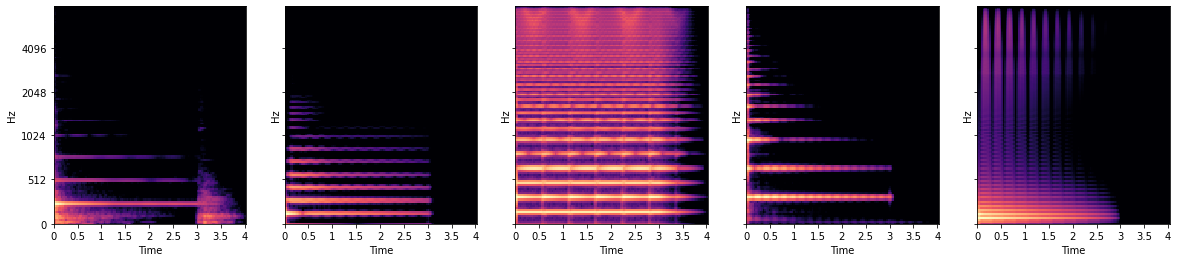

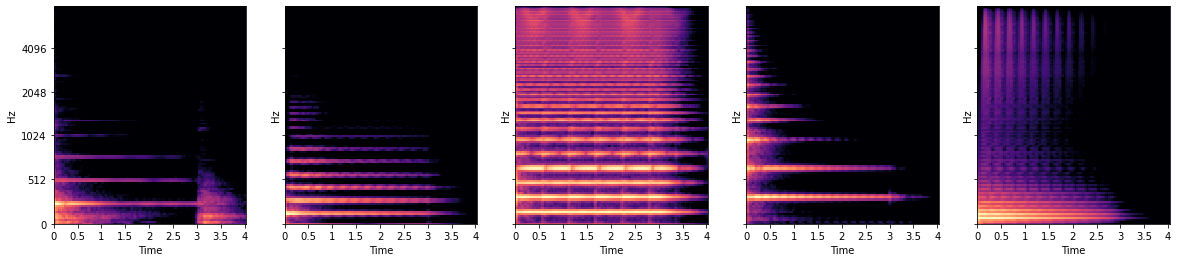

In [5]:
#data["Frequencies"] = freqs
#data['times'] = times
dry_spec_path = base_path + 'spectrograms_dry/'
wet_spec_path = base_path + 'spectrograms_wet/'

dry_specs = [np.load(dry_spec_path + note_str + "_spect.npy") for note_str in data['note_str'].values[:10]]
wet_specs = [np.load(wet_spec_path + note_str + "_spect.npy") for note_str in data['note_str'].values[:10]]

num=5
show_spectrograms(dry_specs[:num], rows=1, cols=num)
show_spectrograms(wet_specs[:num], rows=1, cols=num)





# Next:
- do some data augmentation
- Create dataloader objects
- figure out if there's a way to compute the y's so that the loss function can be less messy
- make the model


    

In [16]:
class EncoderDecoderDataset(Dataset):
    def __init__(self, data):
        self.data = data

        self.dry_spec_path = base_path + 'spectrograms_dry/'
        self.wet_spec_path = base_path + 'spectrograms_wet/'
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        #plt.imshow(self.data.iloc[idx]['spectrogram'])
        #print(self.data.iloc[idx]['note_str'])
        # x = cv2.resize(self.data.iloc[idx]['spectrogram'], (256, 128))
        note_str = self.data.iloc[idx]['note_str']
        #print(note_str)

        x = np.load(self.dry_spec_path + note_str + '_spect.npy')
        y = np.load(self.wet_spec_path + note_str + '_spect.npy')

        pad = np.zeros((128, 1))
        #print(pad.shape)
        #print(x.shape)
        if x.shape[0] == 129 or x.shape[1] ==129:
          #print(note_str)
          #print(x.shape)
          return
        
        x = np.append(x, pad, 1)
        x = np.append(x, pad, 1)
        #print(x.shape)
        #show_spectrogram(x)
        
        
        y = np.append(y, pad, 1)
        y = np.append(y, pad, 1)
        #print(y.shape)
        
        x, y = torch.Tensor(x), torch.Tensor(y)
         

        return x, y

train_data, test_data = train_test_split(data, test_size = .2)  
train_dataset = EncoderDecoderDataset(train_data)
test_dataset = EncoderDecoderDataset(test_data)

train_dl = DataLoader(train_dataset, batch_size=128)
test_dl = DataLoader(test_dataset, batch_size=128)

train_dataset.__getitem__(0)[1]

tensor([[68.6264, 70.5551, 71.7592,  ..., 45.1134,  0.0000,  0.0000],
        [85.2393, 81.0094, 76.3022,  ..., 45.1134,  0.0000,  0.0000],
        [91.1966, 85.4404, 66.9888,  ..., 45.1134,  0.0000,  0.0000],
        ...,
        [85.2061, 80.7007, 71.5163,  ..., 45.1134,  0.0000,  0.0000],
        [81.7483, 77.4784, 64.9530,  ..., 45.1134,  0.0000,  0.0000],
        [54.9166, 50.0233, 45.1134,  ..., 45.1134,  0.0000,  0.0000]])

In [6]:
class AutoencoderDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        #plt.imshow(self.data.iloc[idx]['spectrogram'])
        #print(self.data.iloc[idx]['note_str'])
        # x = cv2.resize(self.data.iloc[idx]['spectrogram'], (256, 128))
        note_str = self.data.iloc[idx]['note_str']
        #print(note_str)

        x = np.load(dry_spec_path + note_str + '_spect.npy')
        y = np.load(dry_spec_path + note_str + '_spect.npy')

        pad = np.zeros((128, 1))
        #print(pad.shape)
        #print(x.shape)
        if x.shape[0] == 129 or x.shape[1] ==129:
          print(note_str)
          print(x.shape)
          return
        
        x = np.append(x, pad, 1)
        x = np.append(x, pad, 1)
        #print(x.shape)
        #show_spectrogram(x)
        
        
        y = np.append(y, pad, 1)
        y = np.append(y, pad, 1)
        
        x, y = torch.Tensor(x), torch.Tensor(y)
         

        return x, y
    
train_data, test_data = train_test_split(data, test_size = .2)  
auto_train_dataset = AutoencoderDataset(train_data)
auto_test_dataset = AutoencoderDataset(test_data)

auto_train_dl = DataLoader(auto_train_dataset, batch_size=128)
auto_test_dl = DataLoader(auto_test_dataset, batch_size=128)


auto_train_dataset.__getitem__(0)[1]

tensor([[67.4178, 67.1234, 66.5735,  ..., 40.5047,  0.0000,  0.0000],
        [70.2894, 71.6520, 67.3949,  ..., 40.5047,  0.0000,  0.0000],
        [69.5753, 70.6048, 70.4589,  ..., 40.5047,  0.0000,  0.0000],
        ...,
        [68.4601, 66.1264, 62.0096,  ..., 40.5047,  0.0000,  0.0000],
        [64.9481, 59.8777, 52.7921,  ..., 40.5047,  0.0000,  0.0000],
        [52.0762, 46.3676, 40.5047,  ..., 40.5047,  0.0000,  0.0000]])

In [8]:
def downsample(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
        nn.BatchNorm2d(out_channels)
    )       

In [9]:
# The encoder portion of our encoder-decoder model
# Should be essentially the same for each model
class Encoder(nn.Module):
    
    def __init__(self, encoding_len):
        super().__init__()
        
        
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, stride=2, padding=1)
        self.relu1 = nn.ReLU(True)

        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU(True)

        self.conv5 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.relu3 = nn.ReLU(True)
        
        
        self.flatten = nn.Flatten(start_dim=1)
    
        self.dense_net = nn.Sequential(
            nn.Linear(32 * 32 * 16, 128), # need this to not be hard coded since idk where this number is coming from
            nn.ReLU(True),
            nn.Linear(128, encoding_len)
        )
        
    def forward(self, x):
        residual = x
        #print(x.shape)
        downsample1 = downsample(1, 16)
        residual = downsample1(x)

        x = self.conv1(x)
        #x = self.conv2(x)
        #print("x shape: {}".format(x.shape))
        #print("res shape: {}".format(residual.shape))
        x = x + residual
        x = self.relu1(x)

        downsample2 = downsample(16, 32)
        residual = downsample2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        x = x + residual
        x = self.relu2(x)
        
        downsample3 = downsample(32, 64)
        residual = downsample3(x)
        x = self.conv5(x)
        #x = self.conv6(x)
        x = x + residual
        x = self.relu3(x)


        #print("pre flatten shape: {}".format(x.shape))
        #x = self.flatten(x)
        #print(x.shape)
        #x = self.dense_net(x)
        
        return x

In [10]:
# the decoder part

class Decoder(nn.Module): 
    
    def __init__(self, encoding_len):
        super().__init__()
        self.dense_net = nn.Sequential(
            nn.Linear(encoding_len, 128),
            nn.ReLU(True),
            nn.Linear(128, 32 * 32 * 16),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 32, 16))
        
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)   
        )
        
    def forward(self, x):
        #x = self.dense_net(x)
        #x = self.unflatten(x)

        #print("post unflatten shape: {}".format(x.shape))
        x = self.cnn(x)
        
        x = torch.sigmoid(x)
        #print("output shape: {}".format(x.shape))
        return x
    

In [162]:
from torchsummary import summary

encoder = Encoder(4)
decoder = Decoder(4)

summary(encoder, (1, 128, 128))
summary(decoder, (128, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
Total params: 23,296
Trainable params: 23,296
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 1.75
Params size (MB): 0.09
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 32, 3, 3], but got 3-dimensional input of size [2, 128, 4] instead

In [11]:
def train_encoder_decoder(train, lr=0.001, n_epochs=25, save_path=base_path+"models/"):
    criterion = nn.MSELoss()
    
    #might actually be #dimensions not length
    encoding_len = 64
    
    encoder = Encoder(encoding_len)
    decoder = Decoder(encoding_len)
    
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
    
    loss_vals = []
    
    # check for GPU
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    encoder.to(device)
    decoder.to(device)
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        
        for x, y in tqdm(train):
            #print(x.shape)
            x, y = x.to(device), y.to(device)
            x = torch.unsqueeze(x, 1)
            y = torch.unsqueeze(y, 1)

            #print(x.shape)
            optim.zero_grad()
            
            #print("input shape: {}".format(x.shape))
            
            enc_out = encoder(x)
            out = decoder(enc_out)
            
            loss = criterion(out, y)
            loss.backward()
            
            optim.step()
            epoch_loss += loss.item()
            
        loss_vals.append(epoch_loss/len(train))

    plt.plot(range(n_epochs), loss_vals)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()  
    
    torch.save(encoder.state_dict(), save_path + "encoder_resblock_{}.pth".format(str(lr)[1:]))
    torch.save(decoder.state_dict(), save_path + "decoder_resblock_{}.pth".format(str(lr)[1:]))
    
    return encoder, decoder, loss_vals
            
            

100%|██████████| 80/80 [01:48<00:00,  1.35s/it]


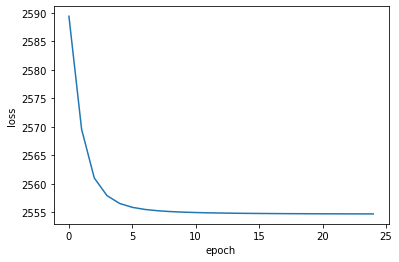

In [164]:
encoder, decoder, losses = train_encoder_decoder(train_dl, lr = 0.001)

In [ ]:
def grid_search():
    """
    train the model a bunch of times, returning the one with the lowest loss
    """

    lrs = [0.0003]
    best_loss = 100000000
    best_lr = 10

    model_dict = {}

    for lr in lrs:
        encoder, decoder, losses = train_encoder_decoder(train_dl, lr=lr, n_epochs=50)
        model_dict[lr] = (encoder, decoder, losses)

        if losses[-1] < best_loss:
            best_lr = lr
    
    return model_dict, best_lr, best_loss
            

100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


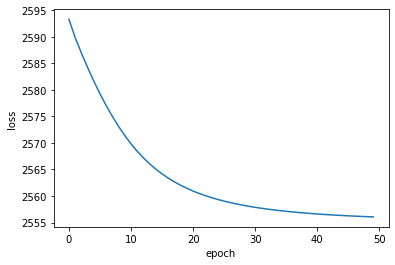

In [40]:
model_dict, best_lr, best_loss = grid_search()

In [165]:
def eval(encoder, decoder, dataloader):
    # put the model into evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():

        xs = []
        outputs = []

        for x, y in tqdm(dataloader):
            device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
            x = x.to(device)
            y = y.to(device)

            x = torch.unsqueeze(x, 1)
            y = torch.unsqueeze(y, 1)

            encoded = encoder(x)
            decoded = decoder(encoded)

            xs.append(x.cpu())
            outputs.append(decoded.cpu())

        expected_tensor = torch.cat(xs)
        out_tensor = torch.cat(outputs)
        
        val_loss = nn.MSELoss()
        val_loss(out_tensor, expected_tensor)

    for i in range(1):
        show_spectrograms(expected_tensor.numpy()[i][0])
        show_spectrograms(out_tensor.numpy()[i][0])
        
       
    return xs, outputs
            

        

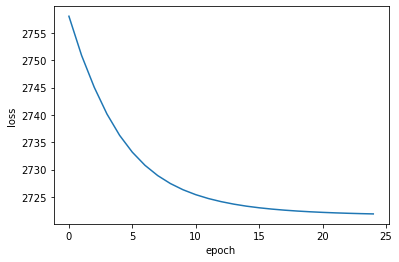

In [62]:
n_epochs = 25
loss_vals = [2758.0319778009166, 2750.8599441480187, 2745.02950173748, 2740.153763154328, 2736.2459820768436, 2733.171990523955, 2730.769919410489, 2728.897983105777, 2727.4421355912364, 2726.302641955836, 2725.40661043474, 2724.6978393939767, 2724.133041237431, 2723.675220573738, 2723.3037294213327, 2723.0085872806585, 2722.7691115129633, 2722.5733900581627, 2722.4123442737086, 2722.2795779832904, 2722.1697401173105, 2722.078580164383, 2722.002787978115, 2721.9396156286966, 2721.886772661179]
plt.plot(range(n_epochs), loss_vals)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


([tensor([[[[ 50.7483,  55.0673,  59.1339,  ...,  43.4433,   0.0000,   0.0000],
            [ 78.5503,  81.0919,  76.6758,  ...,  43.4433,   0.0000,   0.0000],
            [ 90.2956,  90.9074,  82.7213,  ...,  43.4433,   0.0000,   0.0000],
            ...,
            [ 43.4433,  43.4433,  43.4433,  ...,  43.4433,   0.0000,   0.0000],
            [ 43.4433,  43.4433,  43.4433,  ...,  43.4433,   0.0000,   0.0000],
            [ 43.4433,  43.4433,  43.4433,  ...,  43.4433,   0.0000,   0.0000]]],
  
  
          [[[ 75.4473,  72.1691,  48.0525,  ...,  48.0525,   0.0000,   0.0000],
            [ 74.3206,  70.9702,  48.0525,  ...,  48.0525,   0.0000,   0.0000],
            [ 73.3173,  70.0991,  48.0525,  ...,  48.0525,   0.0000,   0.0000],
            ...,
            [ 48.0525,  48.0525,  48.0525,  ...,  48.0525,   0.0000,   0.0000],
            [ 48.0525,  48.0525,  48.0525,  ...,  48.0525,   0.0000,   0.0000],
            [ 48.0525,  48.0525,  48.0525,  ...,  48.0525,   0.0000,   0.0000]

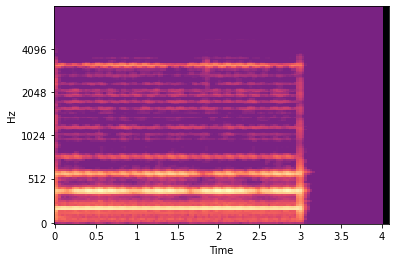

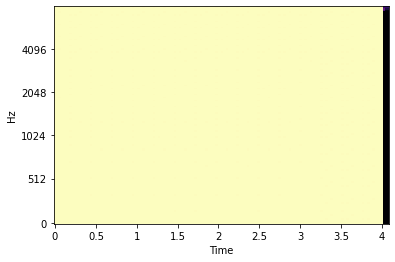

In [166]:
#encoder, decoder, model_losses = model_dict[best_lr]

eval(encoder, decoder, test_dl)

# Citing the Dataset so Google doesn't sue us:

Jesse Engel, Cinjon Resnick, Adam Roberts, Sander Dieleman, Douglas Eck,
  Karen Simonyan, and Mohammad Norouzi. "Neural Audio Synthesis of Musical Notes
  with WaveNet Autoencoders." 2017.

In [13]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )


    def forward(self, input):
        #print(input.shape)
        #print(self.in_channels)
        #print(self.out_channels)
        result = super(CausalConv1d, self).forward(input)

        if self.__padding != 0:
            return result[:, :, : -self.__padding]
        return result

def _conv_stack(dilations, in_channels, out_channels, kernel_size):
    """
    Create stack of dilated convolutional layers, outlined in WaveNet paper:
    https://arxiv.org/pdf/1609.03499.pdf
    """
    return nn.ModuleList(
        [
            CausalConv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                dilation=d,
                kernel_size=kernel_size,
            )
            for i, d in enumerate(dilations)
        ]
    )

class WaveNet(nn.Module):
    def __init__(self, num_channels, dilation_depth, num_repeat, kernel_size=2):
        super(WaveNet, self).__init__()
        dilations = [2 ** d for d in range(dilation_depth)] * num_repeat
        internal_channels = int(num_channels * 2)
        self.hidden = _conv_stack(dilations, num_channels, internal_channels, kernel_size)
        self.residuals = _conv_stack(dilations, num_channels, num_channels, 1)
        self.input_layer = CausalConv1d(
            in_channels=1,
            out_channels=num_channels,
            kernel_size=1,
            groups=1,
        )

        self.linear_mix = nn.Conv1d(
            in_channels=num_channels * dilation_depth * num_repeat,
            out_channels=1,
            kernel_size=1,
        )
        self.num_channels = num_channels

    def forward(self, x):
        out = x
        skips = []

        #print(self.input_layer.__str__)
        
        out = self.input_layer(out)

        for hidden, residual in zip(self.hidden, self.residuals):
            x = out
            out_hidden = hidden(x)

            # gated activation
            #   split (32,16,3) into two (16,16,3) for tanh and sigm calculations
            out_hidden_split = torch.split(out_hidden, self.num_channels, dim=1)
            out = torch.tanh(out_hidden_split[0]) * torch.sigmoid(out_hidden_split[1])

            skips.append(out)

            out = residual(out)
            out = out + x[:, :, -out.size(2) :]

        # modified "postprocess" step:
        out = torch.cat([s[:, :, -out.size(2) :] for s in skips], dim=1)
        out = self.linear_mix(out)
        return out

In [22]:
def train_wavenet(dataloader, n_epochs=10, lr = 0.005, save_path='', net=None):
    criterion = nn.MSELoss()
    
    #might actually be #dimensions not length
    encoding_len = 4
    
    if net == None:
        wavenet = WaveNet(num_channels=1, dilation_depth=2, num_repeat=8)
    else:
        wavenet = net
        
    params_to_optimize = [
        {'params': wavenet.parameters()}
    ]
    
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
    
    loss_vals = []
    
    # check for GPU
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    wavenet.to(device)
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        
        for x, y in tqdm(dataloader):
            #print(x.shape)
            x, y = x.to(device), y.to(device)
            x = torch.flatten(x, start_dim=1)
            y = torch.flatten(y, start_dim=1)

            x = torch.unsqueeze(x, 1)
            y = torch.unsqueeze(y, 1)

            #print(x.shape)
            #print(x.shape)
            
            optim.zero_grad()
            
            #print("input shape: {}".format(x.shape))
            
            wave_out = wavenet(x)
            
            loss = criterion(wave_out, y)
            loss.backward()
            
            optim.step()
            epoch_loss += loss.item()
            
        loss_vals.append(epoch_loss/len(dataloader))
        print('epoch {} loss: {}'.format(epoch, loss_vals[epoch]))

    plt.plot(range(n_epochs), loss_vals)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()  
    
    torch.save(wavenet.state_dict(), base_path + "models/wavenet2_{}.pth".format(str(lr)[2:]))
    
    return wavenet, loss_vals

In [24]:
#wavenet_100 = WaveNet(num_channels=1, dilation_depth=2, num_repeat=4)
#wavenet_100.load_state_dict(torch.load(base_path + "models/wavenet2_0075.pth"))

wavenet_more, wave_losses = train_wavenet(train_dl, lr=0.0075, n_epochs=200, net=None)






  0%|          | 0/80 [00:00<?, ?it/s]




  1%|▏         | 1/80 [00:08<10:56,  8.31s/it]




  2%|▎         | 2/80 [00:16<10:49,  8.33s/it]




  4%|▍         | 3/80 [00:25<10:43,  8.36s/it]




  5%|▌         | 4/80 [00:33<10:42,  8.46s/it]




  6%|▋         | 5/80 [00:42<10:31,  8.42s/it]




  8%|▊         | 6/80 [00:50<10:19,  8.38s/it]




  9%|▉         | 7/80 [00:58<10:09,  8.35s/it]




 10%|█         | 8/80 [01:07<10:00,  8.35s/it]




 11%|█▏        | 9/80 [01:15<09:51,  8.33s/it]




 12%|█▎        | 10/80 [01:23<09:43,  8.34s/it]




 14%|█▍        | 11/80 [01:32<09:44,  8.48s/it]




 15%|█▌        | 12/80 [01:41<09:39,  8.52s/it]




 16%|█▋        | 13/80 [01:49<09:27,  8.46s/it]




 18%|█▊        | 14/80 [01:58<09:22,  8.52s/it]




 19%|█▉        | 15/80 [02:06<09:10,  8.46s/it]




 20%|██        | 16/80 [02:14<08:58,  8.41s/it]




 21%|██▏       | 17/80 [02:23<08:49,  8.40s/it]




 22%|██▎       | 18/80 [02:31<08:49,  8.54s/it]




 24%|██▍       | 19/80 [0

In [17]:
print(wave_losses)

[2525.0966369628904, 2057.675665283203, 1509.9175491333008, 1167.3333267211915, 919.9408813476563, 735.0727806091309, 597.2716552734375, 495.25797538757325, 419.87301712036134, 363.8115798950195, 320.87289962768557, 286.496150970459, 257.8641788482666, 233.2843313217163, 211.7550199508667, 192.71270999908447, 175.82113628387452, 160.83647117614746, 147.55557317733764, 135.78117847442627, 125.32818422317504, 116.04324750900268, 107.79321727752685, 100.45501108169556, 93.91380176544189, 88.05690689086914, 82.76456489562989, 77.96735639572144, 73.62452445030212, 69.67110505104066, 66.08213543891907, 62.796766662597655, 59.8040904045105, 57.075290012359616, 54.58749585151672, 52.31586089134216, 50.23832702636719, 48.33609852790833, 46.595287275314334, 44.98995509147644, 43.51061983108521, 42.12275938987732, 40.813348627090456, 39.594434881210326, 38.39099516868591, 37.3000431060791, 36.33405148983002, 35.46242921352386, 34.6737538099289, 33.954645085334775, 33.29574420452118, 32.6921435832

In [261]:
wavenet2, wave_losses2 = train_wavenet(train_dl, lr=0.007, n_epochs=25)

  0%|          | 0/80 [00:00<?, ?it/s]

torch.Size([128, 1, 16384])


  0%|          | 0/80 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [18]:
def eval_wavenet(wavenet, dataloader):
    # put the model into evaluation mode
    wavenet.eval()
    
    with torch.no_grad():

        xs = []
        outputs = []

        for x, y in tqdm(dataloader):
            device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
            x = x.to(device)
            y = y.to(device)
            #print(x.shape)
            input = torch.flatten(x, start_dim=1)
            y = torch.flatten(y, start_dim=1)

            input = torch.unsqueeze(input, 1)
            y = torch.unsqueeze(y, 1)

            out = wavenet(input)
            #print(out.shape)
            out = out.reshape([x.shape[0], 128, 128])
            
            xs.append(x.cpu())
            outputs.append(out.cpu())

        expected_tensor = torch.cat(xs)
        out_tensor = torch.cat(outputs)
        
        val_loss = nn.MSELoss()
        val_loss(out_tensor, expected_tensor)

    
    #show_spectrogram(expected_tensor.numpy()[0][0])
    #show_spectrogram(out_tensor.numpy()[0][0])
        
       
    return xs, outputs, expected_tensor, out_tensor

In [19]:
xs, outputs, exp_tens, out_tens = eval_wavenet(wavenet2, test_dl)

100%|██████████| 20/20 [00:27<00:00,  1.28s/it]


torch.Size([2536, 128, 128])


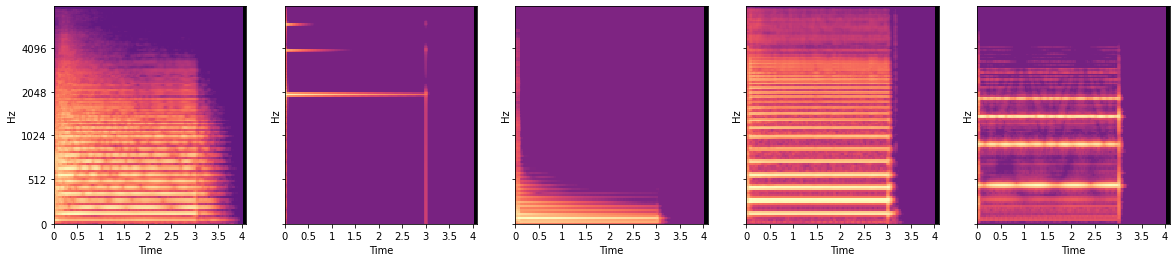

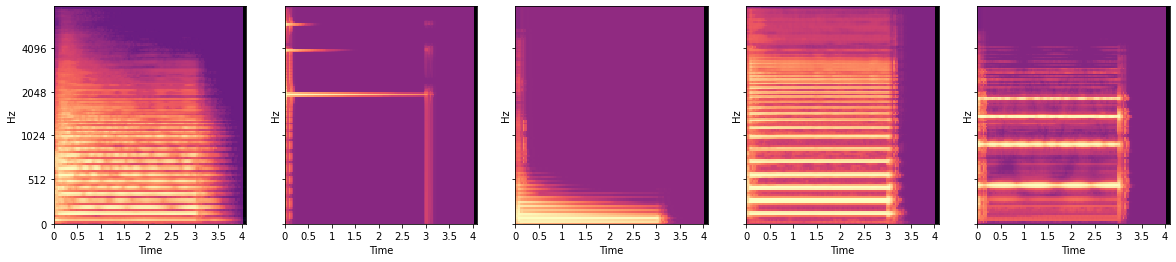

In [20]:
print(exp_tens.shape)
show_spectrograms(exp_tens.numpy()[:5], rows=1, cols=5)
show_spectrograms(out_tens.numpy()[:5], rows=1, cols=5)

In [22]:
import soundfile as sf

def specs_to_wavs(specs, spec_name='neural_reverb'):
    for i in range(len(specs)):
        wav = librosa.feature.inverse.mel_to_audio(specs[i], sr=16000)
        sf.write(base_path + 'audio_samples/' + spec_name + "_{}.wav".format(i), wav, samplerate=16000)

specs_to_wavs(out_tens.numpy(), spec_name='output_reverb')
specs_to_wavs(exp_tens.numpy(), spec_name='gold_reverb')

KeyboardInterrupt: 

In [263]:
summary(wavenet, (1, 16384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      CausalConv1d-1             [-1, 1, 16384]               2
      CausalConv1d-2             [-1, 2, 16384]               6
      CausalConv1d-3             [-1, 1, 16384]               2
      CausalConv1d-4             [-1, 2, 16384]               6
      CausalConv1d-5             [-1, 1, 16384]               2
      CausalConv1d-6             [-1, 2, 16384]               6
      CausalConv1d-7             [-1, 1, 16384]               2
      CausalConv1d-8             [-1, 2, 16384]               6
      CausalConv1d-9             [-1, 1, 16384]               2
     CausalConv1d-10             [-1, 2, 16384]               6
     CausalConv1d-11             [-1, 1, 16384]               2
     CausalConv1d-12             [-1, 2, 16384]               6
     CausalConv1d-13             [-1, 1, 16384]               2
     CausalConv1d-14             [-1, 2